# Schelling Segregation Model

## Background

The Schelling (1971) segregation model is a classic of agent-based modeling, demonstrating how agents following simple rules lead to the emergence of qualitatively different macro-level outcomes. Agents are randomly placed on a grid. There are two types of agents, one constituting the majority and the other the minority. All agents want a certain number (generally, 3) of their 8 surrounding neighbors to be of the same type in order for them to be happy. Unhappy agents will move to a random available grid space. While individual agents do not have a preference for a segregated outcome (e.g. they would be happy with 3 similar neighbors and 5 different ones), the aggregate outcome is nevertheless heavily segregated.

## Implementation

This is a demonstration of running a Mesa model in an IPython Notebook. The actual model and agent code are implemented in Schelling.py, in the same directory as this notebook. Below, we will import the model class, instantiate it, run it, and plot the time series of the number of happy agents.

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

from model import Schelling

Now we instantiate a model instance: a 10x10 grid, with an 80% change of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 3 similar neighbors.

In [2]:
# model = Schelling(10, 10, 0.8, 0.2, 3)
model = Schelling(10, 10, 0.5, 1, 0.8)

We want to run the model until all the agents are happy with where they are. However, there's no guarantee that a given model instantiation will *ever* settle down. So let's run it for either 100 steps or until it stops on its own, whichever comes first:

In [3]:
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps)  # Show how many steps have actually run

100


The model has a DataCollector object, which checks and stores how many agents are happy at the end of each step. It can also generate a pandas DataFrame of the data it has collected:

In [4]:
model_out = model.datacollector.get_model_vars_dataframe()

In [5]:
model_out.head()

,happy,Segregated_Agents
0,0,0.132530
1,64,0.168675
2,67,0.180723
3,71,0.289157
4,73,0.325301


Finally, we can plot the 'happy' series:

<Axes: >

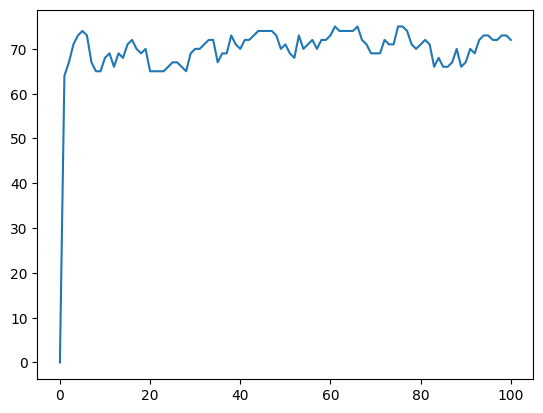

In [6]:
model_out.happy.plot()

For testing purposes, here is a table giving each agent's x and y values at each step.

In [7]:
x_positions = model.datacollector.get_agent_vars_dataframe()

In [8]:
x_positions.head()

x  y  type
Step AgentID            
0    1        0  0     0
     2        0  1     0
     3        0  2     0
     4        0  3     0
     5        0  4     0

# Effect of Homophily on segregation

Now, we can do a parameter sweep to see how segregation changes with homophily.

First, we create a function which takes a model instance and returns what fraction of agents are segregated -- that is, have no neighbors of the opposite type.

In [9]:
import mesa

In [10]:
def get_segregation(model):
    """
    Find the % of agents that only have neighbors of their same type.
    """
    segregated_agents = 0
    for agent in model.schedule.agents:
        segregated = True
        for neighbor in model.grid.iter_neighbors(agent.pos, True):
            if neighbor.type != agent.type:
                segregated = False
                break
        if segregated:
            segregated_agents += 1
    return segregated_agents / model.schedule.get_agent_count()

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's hold everything fixed except for Homophily.

In [11]:
fixed_params = {"height": 10, "width": 10, "density": 0.8, "minority_pc": 0.2}
variable_parms = {"homophily": range(1, 9)}

In [12]:
model_reporters = {"Segregated_Agents": get_segregation}
model.datacollector.model_reporters['Segregated_Agents'] = get_segregation

In [13]:
from mesa.batchrunner import batch_run
import pandas as pd

print(model)

# Define your model parameters
fixed_params = {
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    "seed": None,
}

variable_params = {
    "homophily": [0.1, 0.2, 0.3, 0.4, 0.5],
    "radius": [1, 2, 3],
}

# Combine fixed and variable parameters
params = {**fixed_params, **variable_params}

# Run the batch
results = batch_run(
    Schelling,
    parameters=params,
    iterations=10,
    max_steps=200,
    data_collection_period=-1,
    display_progress=True,
)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
display(results_df)


  0%|          | 0/150 [00:00<?, ?it/s]

,RunId,iteration,Step,height,width,density,minority_pc,seed,homophily,radius,happy,Segregated_Agents,AgentID,x,y,type
0,0,0,3,20,20,0.8,0.2,None,0.1,1,332,0.297297,143,8,15,0
1,0,0,3,20,20,0.8,0.2,None,0.1,1,332,0.297297,213,13,1,1
2,0,0,3,20,20,0.8,0.2,None,0.1,1,332,0.297297,75,4,17,0
3,0,0,3,20,20,0.8,0.2,None,0.1,1,332,0.297297,190,11,13,0
4,0,0,3,20,20,0.8,0.2,None,0.1,1,332,0.297297,148,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47881,149,9,200,20,20,0.8,0.2,None,0.5,3,257,0.207547,242,11,13,1
47882,149,9,200,20,20,0.8,0.2,None,0.5,3,257,0.207547,203,17,18,1
47883,149,9,200,20,20,0.8,0.2,None,0.5,3,257,0.207547,80,5,1,0
47884,149,9,200,20,20,0.8,0.2,None,0.5,3,257,0.207547,67,4,4,0


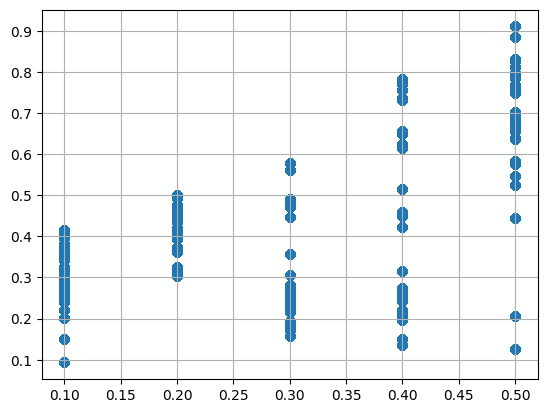

In [14]:
plt.scatter(results_df.homophily, results_df.Segregated_Agents)
plt.grid(True)